In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics.cluster import homogeneity_score
from collections import Counter
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, append=True)

In [2]:
def visualize_embeddings_tSNE(emb_matrix, word_types):
    print("Running tSNE on", emb_matrix.shape, "-dim data")
    tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=250)
    tsne_results = tsne.fit_transform(emb_matrix)
    print('t-SNE done!')
    df_tsne = {'word_type': word_types}
    df_tsne['ax1'] = tsne_results[:, 0]
    df_tsne['ax2'] = tsne_results[:, 1]
    ### Plot data with Plotly
    fig = px.scatter(df_tsne,
                     x='ax1',
                     y='ax2',
                     color='word_type',
                     opacity=0.3
                     )
    fig.update_traces(mode='markers', marker_size=8)
    fig.update_layout(coloraxis={"colorbar":{"dtick":1}})
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.update_yaxes(visible=False, showticklabels=False)
    fig.update_layout(legend=dict(font=dict(size=10)))
    fig.show()
    #save_filename = "figures/ctm_topic_space-tsne-train3000-no_bg.html"
    #fig.write_html(save_filename)


In [3]:
def visualize_embeddings_PCA(emb_matrix, word_types):
    print("Running PCA on", emb_matrix.shape, "-dim matrix")
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(emb_matrix)
    df_pca = {'word_type': word_types}
    df_pca['PC1'] = pca_result[:, 0]
    df_pca['PC2'] = pca_result[:, 1]
    ### Plot data with Plotly
    fig = px.scatter(df_pca,
                     x='PC1',
                     y='PC2',
                     color='word_type',
                     opacity=0.3
                     )
    fig.update_traces(mode='markers', marker_size=8)
    fig.update_layout(coloraxis={"colorbar":{"dtick":1}})
    fig.update_xaxes(visible=False, showticklabels=False)
    fig.update_yaxes(visible=False, showticklabels=False)
    # fig.update_layout(paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
    fig.show()

In [4]:
tasks = ['P', 'PC', 'PCT', 'PT']

df = pd.read_csv("concreteness_norms_last_hidden_state_embs_multitask.csv")

df["task"] = [m.split("/")[0] for m in df.model.tolist()]
df["task"].replace(to_replace="paraphrase", value="P", inplace=True)
df["task"].replace(to_replace="paraphrase-captioning", value="PC", inplace=True)
df["task"].replace(to_replace="paraphrase-captioning-translation", value="PCT", inplace=True)
df["task"].replace(to_replace="paraphrase-translation", value="PT", inplace=True)
df.task.value_counts()

task
P      96720
PC     96720
PCT    96720
PT     96720
Name: count, dtype: int64

In [6]:
df[df.task == 'P'].word_type.value_counts()

word_type
concrete    65400
abstract    31320
Name: count, dtype: int64

In [5]:
# KMeans

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

def compute_purity(data):
    emb_matrix = np.array(data.iloc[:,:512])
    true_labels = data.word_type.tolist()
    kmeans = KMeans(n_clusters=2).fit(emb_matrix)
    y_pred = kmeans.labels_
    purity = purity_score(true_labels, y_pred)
    # print('purity:', purity)
    return purity

def compute_purity_balance_data(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    kmeans = KMeans(n_clusters=2).fit(emb_matrix)
    y_pred = kmeans.labels_
    purity = purity_score(true_labels, y_pred)
    # print('purity:', purity)
    return purity

task_purity = {'task':[], 
               'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity['purity'].extend(model_purity.tolist())
    task_purity['task'].extend([task]*len(model_purity))

Task: P
mean: 0.8271232439335886
std: 0.02346877788426138
Task: PC
mean: 0.8235153256704981
std: 0.025138300944223604
Task: PCT
mean: 0.8187100893997445
std: 0.028661053811986872
Task: PT
mean: 0.8209610472541506
std: 0.02357887347640824


<AxesSubplot:xlabel='task', ylabel='purity'>

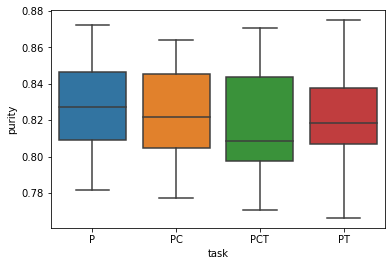

In [6]:
import seaborn as sns
task_purity = pd.DataFrame.from_dict(task_purity)
sns.boxplot(data=task_purity, x="task", y="purity")

In [7]:
from scipy.stats import kruskal
task_purity = pd.DataFrame.from_dict(task_purity)
P_purity = task_purity[task_purity.task == 'P'].purity.to_list()
PC_purity = task_purity[task_purity.task == 'PC'].purity.to_list()
PCT_purity = task_purity[task_purity.task == 'PCT'].purity.to_list()
PT_purity = task_purity[task_purity.task == 'PT'].purity.to_list()
print("P vs PC:", kruskal(P_purity, PC_purity))
print("P vs PCT:", kruskal(P_purity, PCT_purity))
print("P vs PT:", kruskal(P_purity, PT_purity))
print("PC vs PCT:", kruskal(PC_purity, PCT_purity))
print("PC vs PT:", kruskal(PC_purity, PT_purity))
print("PCT vs PT:", kruskal(PCT_purity, PT_purity))

P vs PC: KruskalResult(statistic=0.3278931602889209, pvalue=0.5669023130610245)
P vs PCT: KruskalResult(statistic=2.5831928339450005, pvalue=0.10800361221377876)
P vs PT: KruskalResult(statistic=1.4015068187948128, pvalue=0.23647144294318967)
PC vs PCT: KruskalResult(statistic=1.0903937695653565, pvalue=0.2963839787417357)
PC vs PT: KruskalResult(statistic=0.1267993856471649, pvalue=0.7217739045452587)
PCT vs PT: KruskalResult(statistic=0.6850396285700879, pvalue=0.4078567290721099)


In [11]:
def compute_silhouette_balance_data(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(word_type_counts['abstract'])
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    return metrics.silhouette_score(emb_matrix, true_labels)

task_sil = {'task':[], 
               'sil':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_sil = task_models.groupby("model").apply(lambda x: compute_silhouette_balance_data(x))
    print('mean:', model_sil.mean())
    print('std:', model_sil.std())
    task_sil['sil'].extend(model_sil.tolist())
    task_sil['task'].extend([task]*len(model_sil))

Task: P
mean: 0.051524688137925836
std: 0.00567205730981764
Task: PC
mean: 0.056491768285807556
std: 0.009292752694185497
Task: PCT
mean: 0.056041723803412505
std: 0.006896596876029909
Task: PT
mean: 0.053867491077581195
std: 0.007893187771623872


In [12]:
from scipy.stats import kruskal
task_sil = pd.DataFrame.from_dict(task_sil)
P_sil = task_sil[task_sil.task == 'P'].sil.to_list()
PC_sil = task_sil[task_sil.task == 'PC'].sil.to_list()
PCT_sil = task_sil[task_sil.task == 'PCT'].sil.to_list()
PT_sil = task_sil[task_sil.task == 'PT'].sil.to_list()
print("P vs PC:", kruskal(P_sil, PC_sil))
print("P vs PCT:", kruskal(P_sil, PCT_sil))
print("P vs PT:", kruskal(P_sil, PT_sil))
print("PC vs PCT:", kruskal(PC_sil, PCT_sil))
print("PC vs PT:", kruskal(PC_sil, PT_sil))
print("PCT vs PT:", kruskal(PCT_sil, PT_sil))

P vs PC: KruskalResult(statistic=5.9737037037037055, pvalue=0.014520751247820549)
P vs PCT: KruskalResult(statistic=8.55703703703702, pvalue=0.0034418915096161556)
P vs PT: KruskalResult(statistic=0.944537037037037, pvalue=0.3311137567829102)
PC vs PCT: KruskalResult(statistic=0.06750000000002387, pvalue=0.7950121719642027)
PC vs PT: KruskalResult(statistic=1.4008333333333667, pvalue=0.23658409332186708)
PCT vs PT: KruskalResult(statistic=2.7712037037037476, pvalue=0.09597396513197719)


In [13]:
# Affinity propagation clustering
def compute_purity_balance_data_aff_prop(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    aff_prop = AffinityPropagation().fit(emb_matrix)
    y_pred = aff_prop.labels_
    purity = purity_score(true_labels, y_pred)
    return purity

task_purity_aff_prop = {'task':[], 
                        'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data_aff_prop(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity_aff_prop['purity'].extend(model_purity.tolist())
    task_purity_aff_prop['task'].extend([task]*len(model_purity))

Task: P
mean: 0.8895114942528736
std: 0.007056918304018738
Task: PC


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


mean: 0.8919061302681992
std: 0.006393857148621823
Task: PCT


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


mean: 0.8914272030651341
std: 0.006161515823294774
Task: PT


/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/zosa/.local/lib/python3.10/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


mean: 0.8901021711366539
std: 0.007089899874747479


In [14]:
from scipy.stats import kruskal
task_purity_aff_prop = pd.DataFrame.from_dict(task_purity_aff_prop)
P_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'P'].purity.to_list()
PC_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'PC'].purity.to_list()
PCT_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'PCT'].purity.to_list()
PT_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'PT'].purity.to_list()
print("P vs PC:", kruskal(P_purity, PC_purity))
print("P vs PCT:", kruskal(P_purity, PCT_purity))
print("P vs PT:", kruskal(P_purity, PT_purity))
print("PC vs PCT:", kruskal(PC_purity, PCT_purity))
print("PC vs PT:", kruskal(PC_purity, PT_purity))
print("PCT vs PT:", kruskal(PCT_purity, PT_purity))

P vs PC: KruskalResult(statistic=2.9536702065242646, pvalue=0.08568276575434168)
P vs PCT: KruskalResult(statistic=2.0183946144632245, pvalue=0.15540336565357343)
P vs PT: KruskalResult(statistic=0.2855731654364264, pvalue=0.5930714168606459)
PC vs PCT: KruskalResult(statistic=0.37996289424859203, pvalue=0.5376230953855502)
PC vs PT: KruskalResult(statistic=1.4840031342810516, pvalue=0.22314924363707422)
PCT vs PT: KruskalResult(statistic=0.6862868083207059, pvalue=0.4074302537688401)


In [15]:
# Agglomerative (hierarchical) clustering
def compute_purity_balance_data_agglomerative(data, shuffle_data=True):
    word_type_counts = data.word_type.value_counts()
    abstract = data[data.word_type == 'abstract']
    if shuffle_data is True:
        concrete = data[data.word_type == 'concrete'].sample(frac=1)
        concrete = concrete[:word_type_counts['abstract']]
    else:
        concrete = data[data.word_type == 'concrete'][:word_type_counts['abstract']]
    balanced_data = pd.concat([abstract, concrete])
    emb_matrix = np.array(balanced_data.iloc[:,:512])
    true_labels = balanced_data.word_type.tolist()
    agg = AgglomerativeClustering(n_clusters=None,
                                  metric='cosine',
                                  linkage='average',
                                 distance_threshold=0.5).fit(emb_matrix)
    y_pred = agg.labels_
    #print('leaves:', agg.n_leaves_)
    purity = purity_score(true_labels, y_pred)
    return purity

task_purity_agg = {'task':[], 
                   'purity':[]}
for task in tasks:
    print('Task:', task.upper())
    task_models = df[df.task == task]
    model_purity = task_models.groupby("model").apply(lambda x: compute_purity_balance_data_agglomerative(x))
    print('mean:', model_purity.mean())
    print('std:', model_purity.std())
    task_purity_agg['purity'].extend(model_purity.tolist())
    task_purity_agg['task'].extend([task]*len(model_purity))

Task: P
mean: 0.9285919540229888
std: 0.013719352138136603
Task: PC
mean: 0.9267241379310345
std: 0.012998400024747269
Task: PCT
mean: 0.9272828863346104
std: 0.013532351215380935
Task: PT
mean: 0.9300766283524904
std: 0.01468247284885529


In [16]:
from scipy.stats import kruskal
task_purity_agg = pd.DataFrame.from_dict(task_purity_agg)
P_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'P'].purity.to_list()
PC_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'PC'].purity.to_list()
PCT_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'PCT'].purity.to_list()
PT_purity = task_purity_aff_prop[task_purity_aff_prop.task == 'PT'].purity.to_list()
print("P vs PC:", kruskal(P_purity, PC_purity))
print("P vs PCT:", kruskal(P_purity, PCT_purity))
print("P vs PT:", kruskal(P_purity, PT_purity))
print("PC vs PCT:", kruskal(PC_purity, PCT_purity))
print("PC vs PT:", kruskal(PC_purity, PT_purity))
print("PCT vs PT:", kruskal(PCT_purity, PT_purity))

P vs PC: KruskalResult(statistic=2.9536702065242646, pvalue=0.08568276575434168)
P vs PCT: KruskalResult(statistic=2.0183946144632245, pvalue=0.15540336565357343)
P vs PT: KruskalResult(statistic=0.2855731654364264, pvalue=0.5930714168606459)
PC vs PCT: KruskalResult(statistic=0.37996289424859203, pvalue=0.5376230953855502)
PC vs PT: KruskalResult(statistic=1.4840031342810516, pvalue=0.22314924363707422)
PCT vs PT: KruskalResult(statistic=0.6862868083207059, pvalue=0.4074302537688401)
